# FED_AVG

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import math
import random
import numpy as np


In [ ]:
# --- Settings ---
NUM_CLIENTS = 4
BATCH_SIZE = 128
LEARNING_RATE = 0.01
MOMENTUM = 0.9
ROUNDS = 10
SEED = 42
torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LEARNING_RATE = 0.01
LOCAL_EPOCHS = 5
MU = 0.01  # proximal coefficient
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
# --- Toy dataset (CIFAR10 subset) ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)



In [ ]:
data_per_client = len(train_dataset)//NUM_CLIENTS
client_datasets = random_split(train_dataset, [data_per_client]*NUM_CLIENTS)
client_loaders = [DataLoader(ds, batch_size=len(ds), shuffle=False) for ds in client_datasets]

# Centralized loader (full dataset in one batch)
central_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # self.input_layer = nn.Conv2d(3,16,4,stride = 1)
        self.hidden_layer = nn.Sequential(
            nn.Conv2d(3,32,3,stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32,64,3,stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(64,256,3,stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(4096,512),
            nn.ReLU(),
            nn.Linear(512,10),
        )

    def forward(self, x):
        x = self.hidden_layer(x)
        return x

In [ ]:
def state_dict_to_vector(sd):
    """Flatten a model's state_dict to a vector (CPU)"""
    vecs = [v.detach().cpu().view(-1) for v in sd.values()]
    return torch.cat(vecs) if vecs else torch.tensor([0.0])

def evaluate(model, loader):
    model.eval()
    correct, total, loss_sum = 0, 0, 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            loss_sum += loss.item() * x.size(0)
            _, pred = torch.max(out, 1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return loss_sum/total, 100*correct/total

In [ ]:
def fedprox(global_model, train_loaders, device, local_rounds, mu=0.01):
    criterion = nn.CrossEntropyLoss()
    total_data = sum(len(loader.dataset) for loader in train_loaders)

    global_model.to(device)
    global_params = [torch.zeros_like(p) for p in global_model.parameters()]

    # Save global snapshot at start of round
    global_state = {k: v.detach().clone() for k, v in global_model.state_dict().items()}
    global_vec = state_dict_to_vector(global_state)

    per_client_drifts = []

    # ---------------- local client update ----------------
    for loader in train_loaders:
        local_model = copy.deepcopy(global_model).to(device)
        optimizer = optim.SGD(local_model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

        local_model.train()
        for _ in range(local_rounds):
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()

                # Standard loss
                outputs = local_model(images)
                loss = criterion(outputs, labels)

                # Proximal term μ/2 * ||θ_local - θ_global||²
                prox = 0.0
                for name, param in local_model.state_dict().items():
                    prox += torch.norm(param - global_state[name].to(device)) ** 2

                loss = loss + (mu / 2) * prox

                loss.backward()
                optimizer.step()

        # Drift metric
        local_vec = state_dict_to_vector(local_model.state_dict())
        drift_norm = torch.norm(local_vec - global_vec, p=2).item()
        per_client_drifts.append(drift_norm)

        # Aggregation
        Ni = len(loader.dataset)
        with torch.no_grad():
            for i, param in enumerate(local_model.parameters()):
                global_params[i] += param.data * Ni / total_data

    # ---------------- update global model ----------------
    with torch.no_grad():
        for p, new_p in zip(global_model.parameters(), global_params):
            p.data = new_p.clone()

    return float(np.mean(per_client_drifts))


In [ ]:
ALPHA_DIR = [0.05, 1, 100]
NUM_CLIENTS = 5
LOCAL_ROUNDS = 10
GLOBAL_ROUNDS = 10
LEARNING_RATE = 0.01
MU = 0.01

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"


In [ ]:
from fedlab.utils.dataset.partition import CIFAR10Partitioner

heter_loaders = {}

transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.5,), (0.5,))
  ])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)

for a in ALPHA_DIR:
    hetero_dir_part = CIFAR10Partitioner(
        train_dataset.targets,
        NUM_CLIENTS,
        balance=None,
        partition="dirichlet",
        dir_alpha=a,
        seed=SEED
    )

    client_loaders = [
        DataLoader(Subset(train_dataset, hetero_dir_part.client_dict[i]), batch_size=BATCH_SIZE, shuffle=True)
        for i in range(NUM_CLIENTS)
    ]

    heter_loaders[a] = client_loaders

In [ ]:
alpha_accuracies = []
alpha_losses = []
alpha_drifts = []

initialisation_model = SimpleCNN()
print(f"---- Global Rounds = {GLOBAL_ROUNDS}, Local Rounds = {LOCAL_ROUNDS} ----")

for alpha, train_loaders in heter_loaders.items():
    print(f"a = {alpha}")
    global_model = copy.deepcopy(initialisation_model)
    drifts = []

    for round in range(GLOBAL_ROUNDS):
        avg_drift = fedprox(global_model, train_loaders, device, LOCAL_ROUNDS, mu=MU)
        drifts.append(avg_drift)

        fed_loss, fed_acc = evaluate(global_model, test_loader)
        print(f"Round {round+1:02d}:")
        print(f"  FedProx → Test Loss: {fed_loss:.4f}, Test Acc: {fed_acc:.2f}%, Avg Drift: {avg_drift}")

    alpha_drifts.append(drifts)
    alpha_accuracies.append(fed_acc)
    alpha_losses.append(fed_loss)

    torch.save(global_model.state_dict(), f"global_model_alpha_{alpha}.pth")


---- Global Rounds = 10, Local Rounds = 10 ----
a = 0.05
Round 01:
  FedProx → Test Loss: 2.1922, Test Acc: 14.80%, Avg Drift: 4.469423937797546
Round 02:
  FedProx → Test Loss: 1.7423, Test Acc: 39.15%, Avg Drift: 4.33498969078064
Round 03:
  FedProx → Test Loss: 1.6213, Test Acc: 42.00%, Avg Drift: 4.143811058998108
Round 04:
  FedProx → Test Loss: 1.3418, Test Acc: 53.20%, Avg Drift: 3.768459510803223
Round 05:
  FedProx → Test Loss: 1.6992, Test Acc: 48.90%, Avg Drift: 3.0208020210266113
Round 06:
  FedProx → Test Loss: 1.6932, Test Acc: 50.93%, Avg Drift: 2.8630277633666994
Round 07:
  FedProx → Test Loss: 3.5328, Test Acc: 31.59%, Avg Drift: 2.6878395080566406
Round 08:
  FedProx → Test Loss: 1.9414, Test Acc: 43.68%, Avg Drift: 3.956851768493652
Round 09:
  FedProx → Test Loss: 2.3332, Test Acc: 43.71%, Avg Drift: 2.5777759552001953
Round 10:
  FedProx → Test Loss: 2.6468, Test Acc: 42.33%, Avg Drift: 2.595900297164917
a = 1
Round 01:
  FedProx → Test Loss: 1.7681, Test Acc: 41.

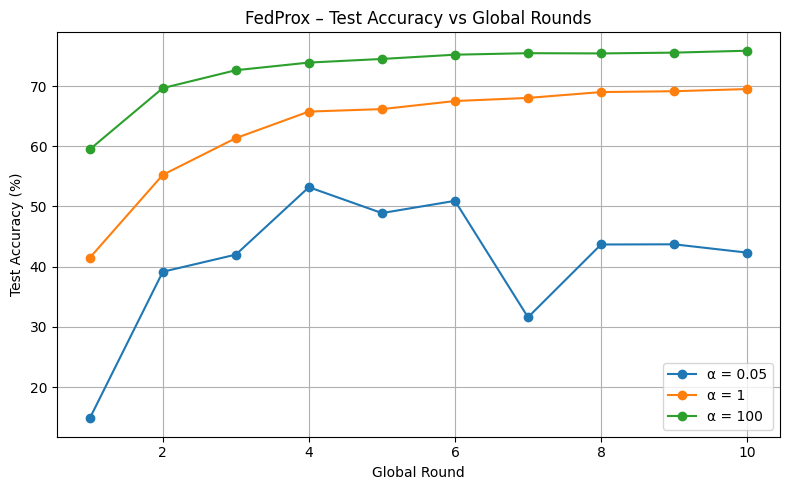

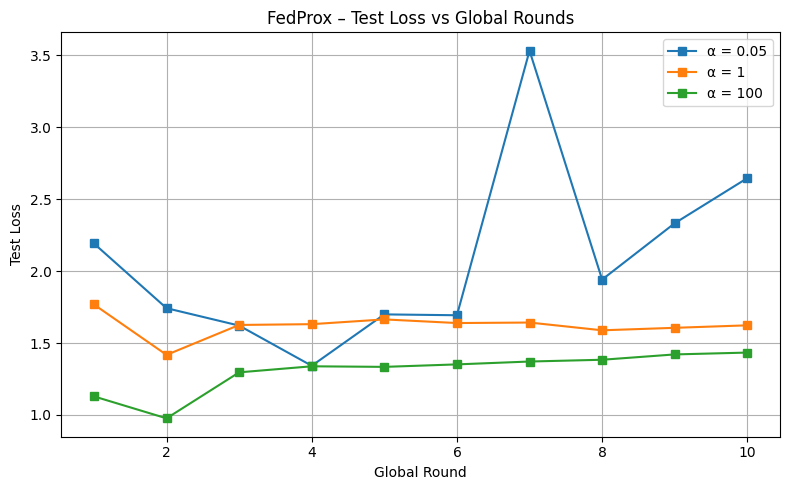

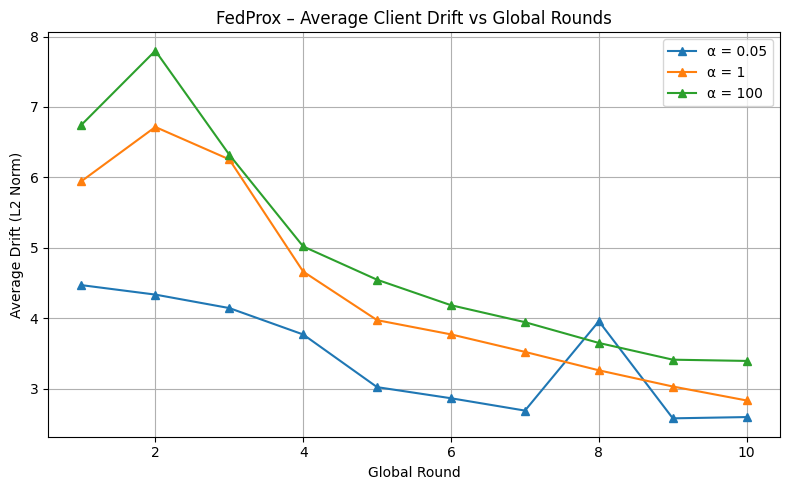

In [ ]:
import matplotlib.pyplot as plt

rounds = list(range(1, 11))

# -------------------------------
# α = 0.05
# -------------------------------
acc_005 = [14.80, 39.15, 42.00, 53.20, 48.90, 50.93, 31.59, 43.68, 43.71, 42.33]
loss_005 = [2.1922, 1.7423, 1.6213, 1.3418, 1.6992, 1.6932, 3.5328, 1.9414, 2.3332, 2.6468]
drift_005 = [4.4694, 4.3350, 4.1438, 3.7685, 3.0208, 2.8630, 2.6878, 3.9569, 2.5778, 2.5959]

# -------------------------------
# α = 1
# -------------------------------
acc_1 = [41.47, 55.25, 61.35, 65.76, 66.17, 67.51, 68.03, 69.00, 69.14, 69.50]
loss_1 = [1.7681, 1.4176, 1.6257, 1.6312, 1.6643, 1.6390, 1.6425, 1.5885, 1.6058, 1.6231]
drift_1 = [5.9449, 6.7153, 6.2549, 4.6620, 3.9719, 3.7699, 3.5215, 3.2597, 3.0297, 2.8314]

# -------------------------------
# α = 100
# -------------------------------
acc_100 = [59.48, 69.66, 72.63, 73.90, 74.50, 75.21, 75.46, 75.42, 75.55, 75.87]
loss_100 = [1.1289, 0.9763, 1.2962, 1.3382, 1.3342, 1.3515, 1.3714, 1.3837, 1.4208, 1.4336]
drift_100 = [6.7455, 7.7983, 6.3220, 5.0189, 4.5460, 4.1841, 3.9435, 3.6483, 3.4108, 3.3931]

# ----------------------------------------------------
# Plot 1: Accuracy
# ----------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(rounds, acc_005, marker='o', label="α = 0.05")
plt.plot(rounds, acc_1, marker='o', label="α = 1")
plt.plot(rounds, acc_100, marker='o', label="α = 100")
plt.title("FedProx – Test Accuracy vs Global Rounds")
plt.xlabel("Global Round")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------------------------------
# Plot 2: Loss
# ----------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(rounds, loss_005, marker='s', label="α = 0.05")
plt.plot(rounds, loss_1, marker='s', label="α = 1")
plt.plot(rounds, loss_100, marker='s', label="α = 100")
plt.title("FedProx – Test Loss vs Global Rounds")
plt.xlabel("Global Round")
plt.ylabel("Test Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------------------------------
# Plot 3: Client Drift
# ----------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(rounds, drift_005, marker='^', label="α = 0.05")
plt.plot(rounds, drift_1, marker='^', label="α = 1")
plt.plot(rounds, drift_100, marker='^', label="α = 100")
plt.title("FedProx – Average Client Drift vs Global Rounds")
plt.xlabel("Global Round")
plt.ylabel("Average Drift (L2 Norm)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
